# Approximating OT with sampling scheme

In [45]:
import itertools
from pathlib import Path

import numpy as np
import pandas as pd 
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns 
%matplotlib notebook
sns.set_style("whitegrid")


from estimate_ot import (
    KMeansInit, MCKMeansInit, EmpiricalSampler,
    KMeansInitRegularized, MCKMeansInitRegularized, EmpiricalSamplerRegularized,
    KMeansInitLloydRefinement, MCKMeansInitLloydRefinement,
    
    ContinuousDistribution, FiniteDistribution, ot_gaussian,
    
    emd, sinkhorn, EMDOutput
                          )

from estimate_ot.benchmark_estimate import benchmark_ot, join_benchmarks
from plot_utils import add_linear_regression, result_to_axes, savefig, CMAPS_SEQUENTIAL, FONTSIZE_LEGEND

## Plots

### Redoing plots

You can use the `result_to_ax` function or whatever you like. It's a tool to deal with the mean/groupby. 

Usually, `results` have comlumns: 
* `method`: method used. `kmeans`, `empirical`.
* `samples`: number of samples (fixed computational cost).
* `run`: id of the run. Usually 1 to 100.
* `cost`: OT cost.
* `t_fit`: time to fit the LP solver.
* `t_tot`: total time of the estimation (preprocessing + t_fit).
* `bias`: np.abs(cost - true_ot)
* `rel_bias`: bias/true_ot
* `std`, *or* `dim`: misc. info on the experiment

### Running your own experiment

To estimate OT, you choose an estimator in `estimate_ot/estimate_ot.py`. 
One estimator object = two distributions, which are attributes of this estimator. 
A distribution can be either Continuous or Finite. See `estimate_ot/distribution/distribution.py`.

So if you want to estimate OT between two Gaussian, you use: 

In [2]:
# Caracteristics
dim = 2

alpha_means = np.zeros(dim)
beta_means = np.ones(dim)
cov = np.eye(dim)

# Declare the distributions
alpha = ContinuousDistribution.gaussian(alpha_means, cov)
beta = ContinuousDistribution.gaussian(beta_means, cov)

You can plot a few samples: 

<IPython.core.display.Javascript object>


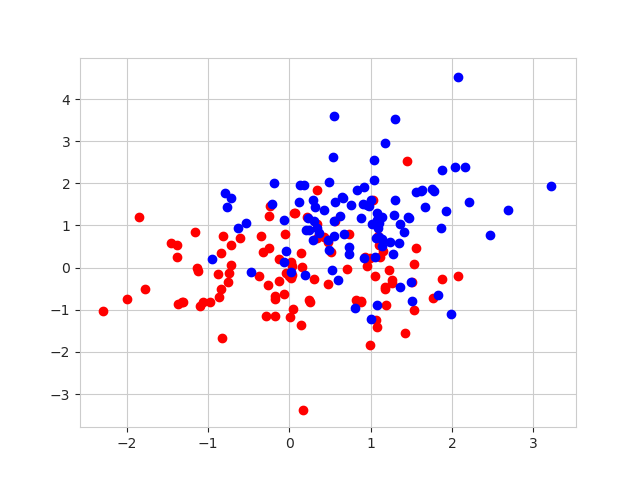

In [3]:
alpha.plot(100, c='r')
beta.plot(100, c='b')

Then you choose the estimator:

In [4]:
estimator_our = KMeansInit(alpha, beta)
estimator_naive = EmpiricalSampler(alpha, beta)

You can estimate with `evaluate()`, or use the `benchmark_ot` (see below). 

In [5]:
result_our = estimator_our.evaluate(10, n_runs=10)
result_naive = estimator_naive.evaluate(10, n_runs=10)

print(f"Estimation on 10 runs, with k=10:\n",
      f"Ours : {np.mean(result_our):.2f} +/- {np.std(result_our):.2f}\n"
      f" Naive: {np.mean(result_naive):.2f} +/- {np.std(result_naive):.2f}")

Estimation on 10 runs, with k=10:
 Ours : 2.63 +/- 0.36
 Naive: 2.60 +/- 0.95


This notebook being a bit long, I suggest using the [table of content](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/toc2/README.html) extension of Jupyter notebook, to travel swiftly through this page.

## Gaussians

### Distributions

Define the distributions we will be working with.

In [64]:
# Experiment information
dim = 5
save_dir = Path('data/gaussian')
assert save_dir.is_dir()

# Gaussian caracteristics
alpha_means = np.zeros(dim)
beta_means = np.ones(dim)
cov = np.eye(dim)

alpha = {}
beta = {}

# Multiple standard deviation are tried
for std in [1, 1e-4]:
    alpha[std] = ContinuousDistribution.gaussian(alpha_means, cov * std)
    beta[std] = ContinuousDistribution.gaussian(beta_means, cov * std)

Define the true distance between them:


In [65]:
true_ot = {}
for std in alpha:
    true_ot[std] = ot_gaussian(alpha_means, beta_means, cov * std, cov * std) ** .5

Visual check:

<IPython.core.display.Javascript object>


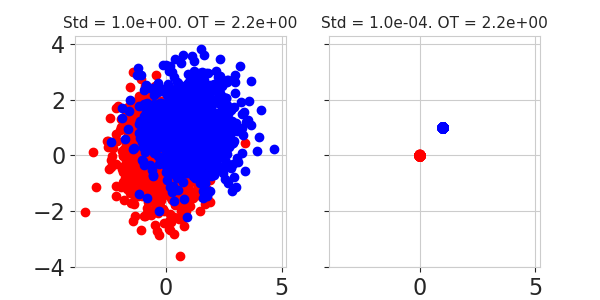

In [66]:
fig, axes = plt.subplots(1, len(alpha), figsize=(6, 3), sharex=True, sharey=True)

for ax, std in zip(axes, alpha):
    alpha[std].plot(1000, color='r', ax=ax)
    beta[std].plot(1000, color='b', ax=ax)
    ax.set_title(f"Std = {std:.1e}. OT = {true_ot[std]:.1e}", fontsize=11)

### Define the estimators

Now, define the estimators you want to use: 

In [67]:
# Prefactor on the number of samples (Kappa in the article)
prefactor_sampling=1

# Choose L1 or L2 norm
metric_norm = 2

# Uncomment the estimators you wish to test
estimators = {std: 
              {"kmeans": KMeansInit(alpha[std], beta[std], prefactor_sampling=prefactor_sampling, metric_norm=metric_norm),
               "mc_kmeans": MCKMeansInit(alpha[std], beta[std], chain_length=100, r_sampled=2.,
                                         prefactor_sampling=prefactor_sampling, metric_norm=metric_norm),
               "empirical": EmpiricalSampler(alpha[std], beta[std], metric_norm=2)
               # "kmeans_refined": KMeansInitLyoddRefinement(...)
               # "mc_kmeans_refined": MCKMeansInitLloydRefinement(...)
               }
              for std in alpha}

### Benchmark!

Run the benchmark.

In [68]:
# Number of runs per settings
n_batch = 10  # Change to 100 for more precise estimation, keep 10 for faster results.

# Number of `k` to try for each estimator
val_to_try = {
    "kmeans": np.logspace(0, 2, 10),
    "mc_kmeans": np.logspace(0, 2, 10),
    "empirical": np.logspace(0, 2, 10),
             }

# Remove duplicate and do longest first
val_to_try = {k: np.flip(np.unique(v.astype(int))) for k, v in val_to_try.items()}

val_to_try

{'kmeans': array([100,  59,  35,  21,  12,   7,   4,   2,   1]),
 'mc_kmeans': array([100,  59,  35,  21,  12,   7,   4,   2,   1]),
 'empirical': array([100,  59,  35,  21,  12,   7,   4,   2,   1])}

In [69]:
results = {}
for std in alpha:
    # Loop over every std
    print(f"Doing std: {std}.\n")
    result_std = []
    
    for name, model in estimators[std].items():
        # Loop over every models
        print(f"\tDoing model: {name}.")
        # Set sqrt_cost to FALSE if doing L1 experiments
        result_benchmark = benchmark_ot(model, val_to_try[name], n_batch, sqrt_cost=True)
        result_std.append((name, result_benchmark))
    
    # Process the benchmark
    results[std] = join_benchmarks(result_std, optimal_cost=true_ot[std])
    results[std]['std'] = std

# Concat everything
results = pd.concat(results.values())

Doing std: 1.

	Doing model: kmeans.



	Doing model: mc_kmeans.



	Doing model: empirical.



Doing std: 0.0001.

	Doing model: kmeans.



	Doing model: mc_kmeans.



	Doing model: empirical.


### Plots

To reproduce the figures of the article, run the following:

<IPython.core.display.Javascript object>


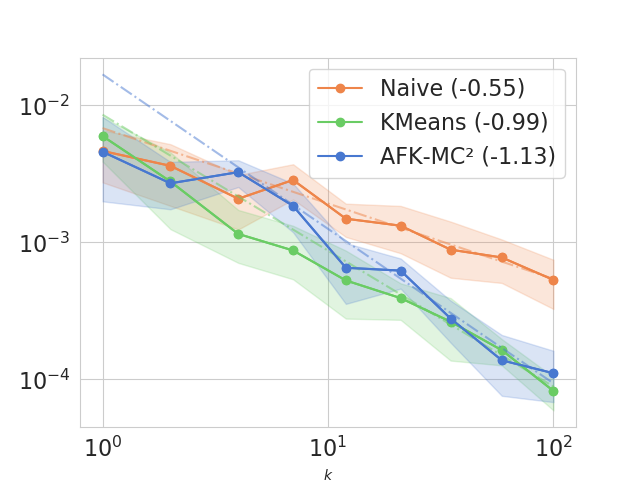

In [29]:
### BIAS PLOTS -- to reproduce those of the article 

df = results[results['method'].isin(['empirical', 'kmeans', 'mc_kmeans'])
                      & results['std'].isin([1e-4])] # Choose a different std here

fig, ax = plt.subplots()
_ = result_to_axes(df,
                   hue='method', x='samples', y='rel_bias', 
                   axes=ax,
                   hue_names={'kmeans': "KMeans", 
                              "mc_kmeans": "AFK-MC²",
                              "empirical": "Naive"},
                   hue_color={'kmeans': CMAPS_SEQUENTIAL[1], 
                              "mc_kmeans": CMAPS_SEQUENTIAL[2],
                              'empirical': CMAPS_SEQUENTIAL[0]},
                   xylabels=('$k$', ""),
                   quantile=0.5, 
                   ci=True)

# savefig(fig, save_dir, name='gaussian_1_ERRORBAR.pdf')

<IPython.core.display.Javascript object>


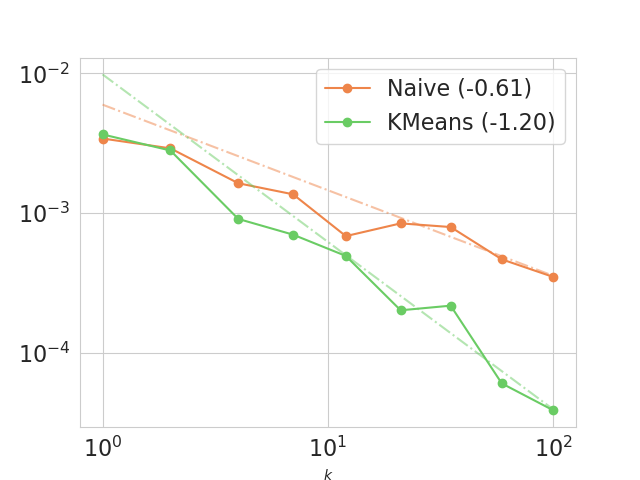

In [30]:
### STANDARD DEVIATION PLOTS

fig, ax = plt.subplots()
df = results.groupby(['method', 'std', 'samples'])['rel_bias'].std().reset_index()
df = df[df['method'].isin(['kmeans', 'empirical'])
        & df['std'].isin([1e-4])]

_ = result_to_axes(df,
                   hue='method', x='samples', y='rel_bias',  # rel_bias is the right column; the `groupby` took its std.
                   axes=ax,
                   hue_names={'kmeans': "KMeans", 
                              "mc_kmeans": "AFK-MC²",
                              "empirical": "Naive"},
                   hue_color={'kmeans': CMAPS_SEQUENTIAL[1], 
                              "mc_kmeans": CMAPS_SEQUENTIAL[2],
                              'empirical': CMAPS_SEQUENTIAL[0]},
                   xylabels=('$k$', ""),
                   quantile=.5,
                   ci=False)

# savefig(fig, save_dir, name='gaussian_4_STD.pdf')

Or you can simply use seaborn, which is faster but does not provide the regression coefficients.

<IPython.core.display.Javascript object>


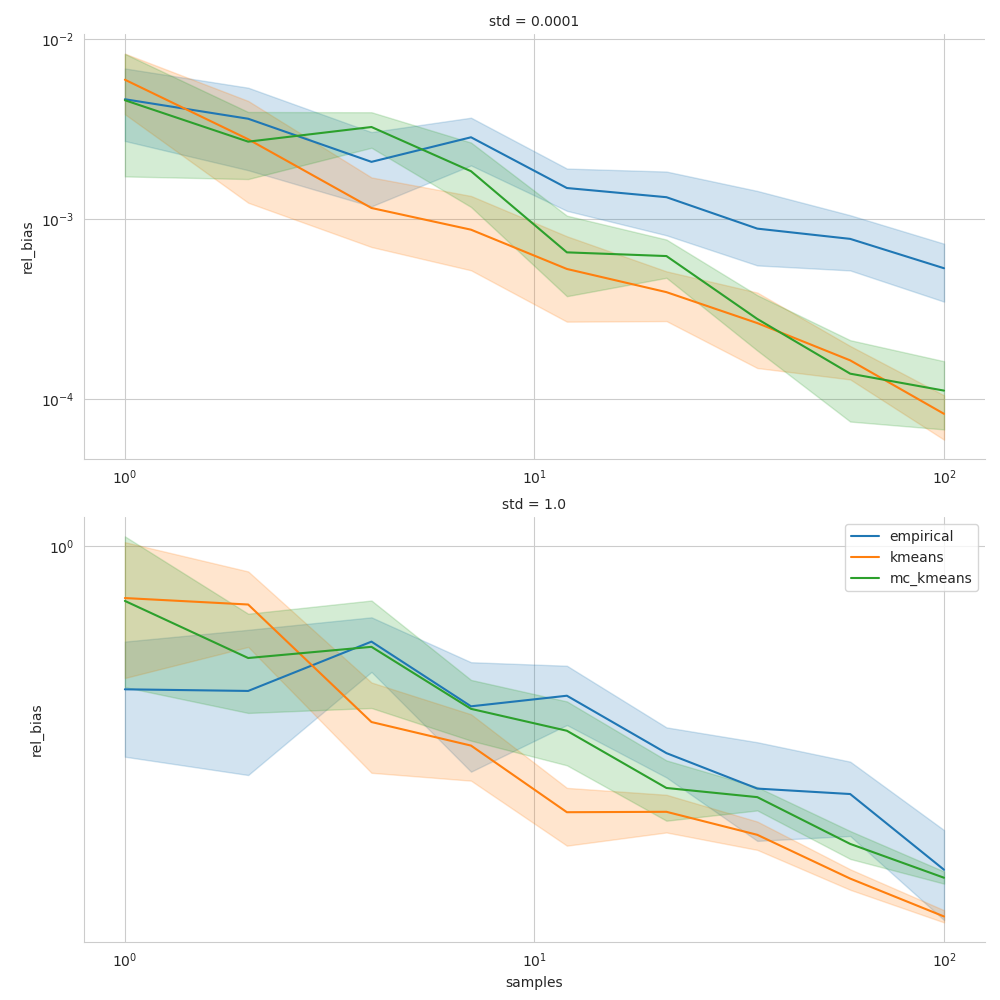

In [36]:
g = sns.FacetGrid(results, hue='method', row="std", sharey=False, sharex=False, height=5, aspect=1.5)
g = g.map(sns.lineplot, "samples", "rel_bias")
g = g.set(xscale='log', yscale='log')
plt.legend()

### Exhibiting Lloyd improvement

Here is how you can proceed to compare our estimator with the same preprocessing, with a few more Lloyd's algorithm steps.

In [55]:
# Prefactor on the number of samples (Kappa in the article)
prefactor_sampling=.1

# Choose L1 or L2 norm
metric_norm = 2

# Uncomment the estimators you wish to test
estimators = {std: 
              {"kmeans": KMeansInit(alpha[std], beta[std], prefactor_sampling=prefactor_sampling, metric_norm=metric_norm),
               "kmeans_refined": KMeansInitLloydRefinement(alpha[std], beta[std], prefactor_sampling=prefactor_sampling, metric_norm=metric_norm),
               }
              for std in alpha}

In [56]:
# Number of runs per settings
n_batch = 10  # Change to 100 for more precise estimation, keep 10 for faster results.

# Number of `k` to try for each estimator
val_to_try = {
    "kmeans": np.logspace(0, 2, 10),
    "kmeans_refined": np.logspace(0, 2, 10),
    "empirical": np.logspace(0, 2, 10),
             }

# Remove duplicate and do longest first
val_to_try = {k: np.flip(np.unique(v.astype(int))) for k, v in val_to_try.items()}

val_to_try

{'kmeans': array([100,  59,  35,  21,  12,   7,   4,   2,   1]),
 'kmeans_refined': array([100,  59,  35,  21,  12,   7,   4,   2,   1]),
 'empirical': array([100,  59,  35,  21,  12,   7,   4,   2,   1])}

In [57]:
results = {}
for std in alpha:
    # Loop over every std
    print(f"Doing std: {std}.\n")
    result_std = []
    
    for name, model in estimators[std].items():
        # Loop over every models
        print(f"\tDoing model: {name}.")
        # Set sqrt_cost to FALSE if doing L1 experiments
        result_benchmark = benchmark_ot(model, val_to_try[name], n_batch, sqrt_cost=True)
        result_std.append((name, result_benchmark))
    
    # Process the benchmark
    results[std] = join_benchmarks(result_std, optimal_cost=true_ot[std])
    results[std]['std'] = std

# Concat everything
results = pd.concat(results.values())

Doing std: 1.

	Doing model: kmeans.



	Doing model: kmeans_refined.



Doing std: 0.0001.

	Doing model: kmeans.



	Doing model: kmeans_refined.


<IPython.core.display.Javascript object>


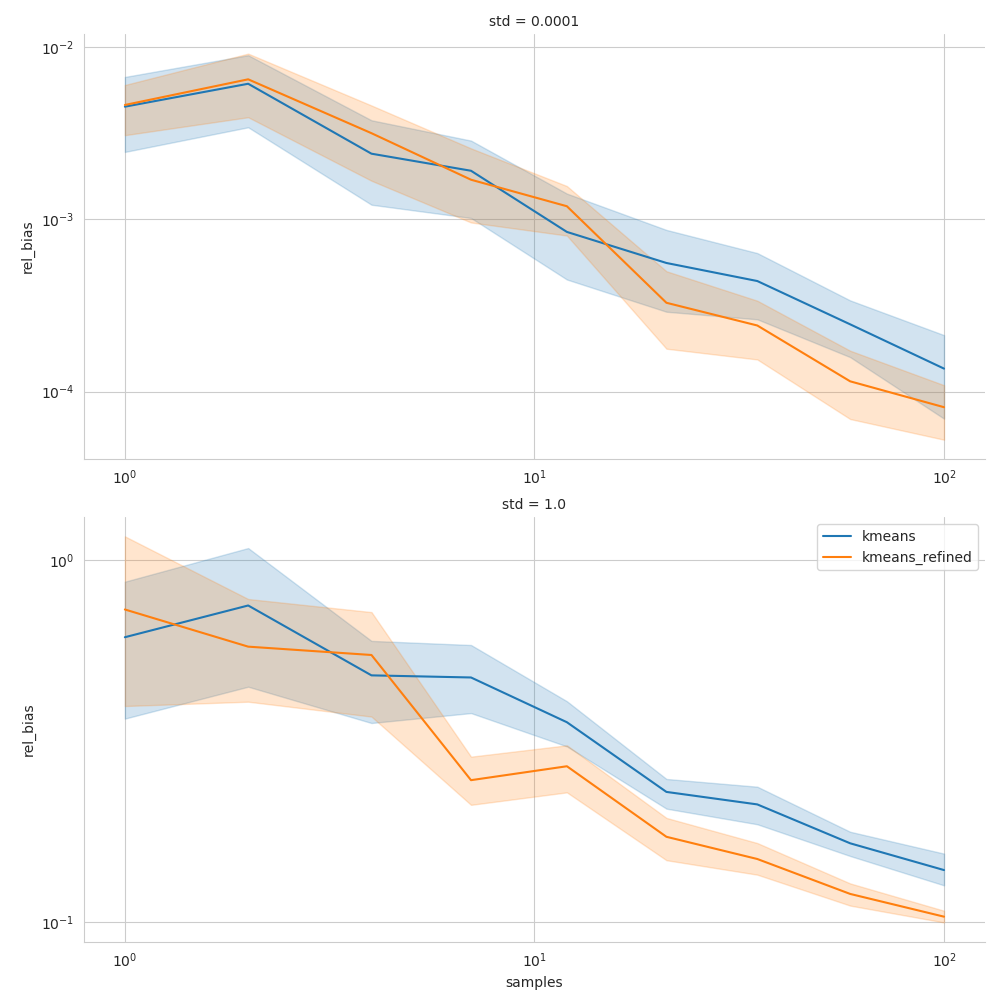

In [58]:
g = sns.FacetGrid(results, hue='method', row="std", sharey=False, sharex=False, height=5, aspect=1.5)
g = g.map(sns.lineplot, "samples", "rel_bias")
g = g.set(xscale='log', yscale='log')
plt.legend()

The next sections exhibit the exactly same process. 

## Fragmented hypercube

This is essentially the same as the `Gaussian` example. The parameter of the experiment is the dimension rather than the standard deviation.

### Distributions

In [70]:
from functools import partial
save_dir = Path('data/hypercube/')
assert save_dir.is_dir()

def sample_X(n, dim):
    return np.random.uniform(-1, 1, (n, dim))

def sample_Y(n, dim):
    X = sample_X(n, dim)
    return X + 2 * np.concatenate([np.sign(X[:, :2]), np.zeros((n, dim-2))], axis=1)

alpha, beta = {}, {}
for dim in [2, 8]:
    alpha[dim] = ContinuousDistribution(partial(sample_X, dim=dim))
    beta[dim] = ContinuousDistribution(partial(sample_Y, dim=dim))

optimal_cost = 8 ** .5

<IPython.core.display.Javascript object>


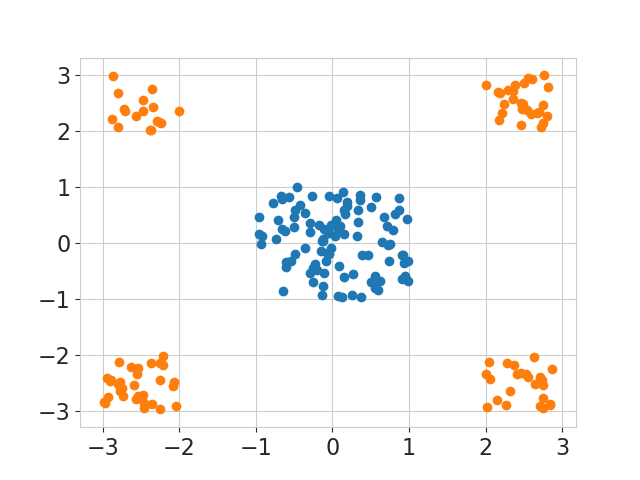

In [71]:
fig, ax = plt.subplots()
alpha[2].plot(100)
beta[2].plot(100)

### Define the estimators

In [72]:
# Prefactor on the number of samples (Kappa in the article)
prefactor_sampling=1

# Choose L1 or L2 norm
metric_norm = 2

# Uncomment the estimators you wish to test
estimators = {std: 
              {"kmeans": KMeansInit(alpha[std], beta[std], prefactor_sampling=prefactor_sampling, metric_norm=metric_norm),
               "mc_kmeans": MCKMeansInit(alpha[std], beta[std], chain_length=100, r_sampled=2.,
                                         prefactor_sampling=prefactor_sampling, metric_norm=metric_norm),
               "empirical": EmpiricalSampler(alpha[std], beta[std], metric_norm=2)
               # "kmeans_refined": KMeansInitLyoddRefinement(...)
               # "mc_kmeans_refined": MCKMeansInitLloydRefinement(...)
               }
              for std in alpha}

### Benchmark!

In [73]:
n_batch = 10
val_to_try = np.logspace(0, 2, 10).astype(int)
val_to_try = np.flip(np.unique(val_to_try))

val_to_try

array([100,  59,  35,  21,  12,   7,   4,   2,   1])

In [74]:
results = {}
for dim in alpha:
    print(f"Doing dim: {dim}.\n")
    result_dim = []
    for name, model in estimators[dim].items():
        print(f"\tDoing model: {name}.")
        result_benchmark = benchmark_ot(model, val_to_try, n_batch, sqrt_cost=True)
        result_dim.append((name, result_benchmark))
    results[dim] = join_benchmarks(result_dim, optimal_cost=optimal_cost)
    results[dim]['dim'] = dim
results = pd.concat(results.values())

Doing dim: 2.

	Doing model: kmeans.



	Doing model: mc_kmeans.



	Doing model: empirical.



Doing dim: 8.

	Doing model: kmeans.



	Doing model: mc_kmeans.



	Doing model: empirical.


### Plots

<IPython.core.display.Javascript object>


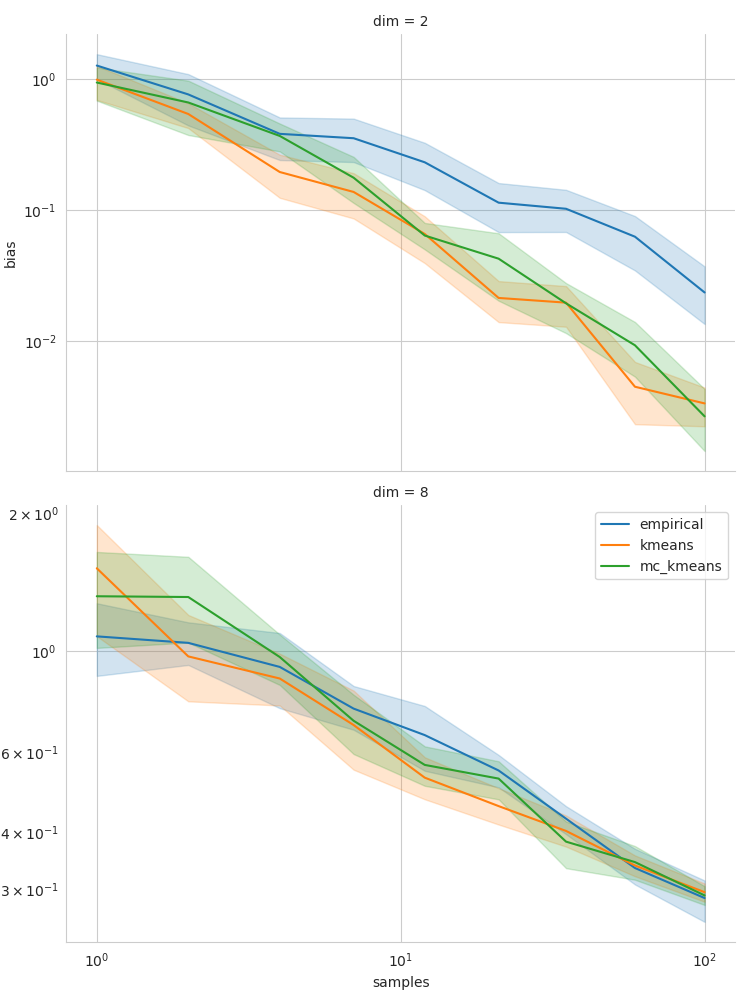

In [65]:
g = sns.FacetGrid(results, hue='method', row="dim", sharey=False, height=5, aspect=1.5)
g = g.map(sns.lineplot, "samples", "bias")
g = g.set(xscale='log', yscale='log')
plt.legend()

## Uniform

This distribution shows that the quantization error gets very big for spread data.

### Distributions

In [75]:
from functools import partial

save_dir = Path('data/uniform/')
assert save_dir.is_dir()

alpha, beta = {}, {}
for dim in [2, 12]:
    alpha[dim] = ContinuousDistribution(lambda n: np.random.random_sample((n, dim)))
    beta[dim] = ContinuousDistribution(lambda n: np.random.random_sample((n, dim)))

optimal_cost = 0

In [76]:
estimators = {"kmeans": KMeansInit, 
              "empirical": EmpiricalSampler,
             }

### Define the estimators

In [77]:
estimators = {dim: {name: model(alpha[dim], beta[dim]) for name, model in estimators.items()} for dim in alpha}

### Benchmark!

In [78]:
n_batch = 10
val_to_try = np.logspace(0, 2, 10).astype(int)
val_to_try = np.flip(np.unique(val_to_try))

val_to_try

array([100,  59,  35,  21,  12,   7,   4,   2,   1])

In [79]:
results = {}
for dim in alpha:
    print(f"Doing dim: {dim}.\n")
    result_dim = []
    for name, model in estimators[dim].items():
        print(f"\tDoing model: {name}.")
        result_benchmark = benchmark_ot(model, val_to_try, n_batch, sqrt_cost=True)
        result_dim.append((name, result_benchmark))
    results[dim] = join_benchmarks(result_dim, optimal_cost=optimal_cost)
    results[dim]['dim'] = dim
results = pd.concat(results.values())

Doing dim: 2.

	Doing model: kmeans.



	Doing model: empirical.



Doing dim: 12.

	Doing model: kmeans.



	Doing model: empirical.


### Plots

<IPython.core.display.Javascript object>


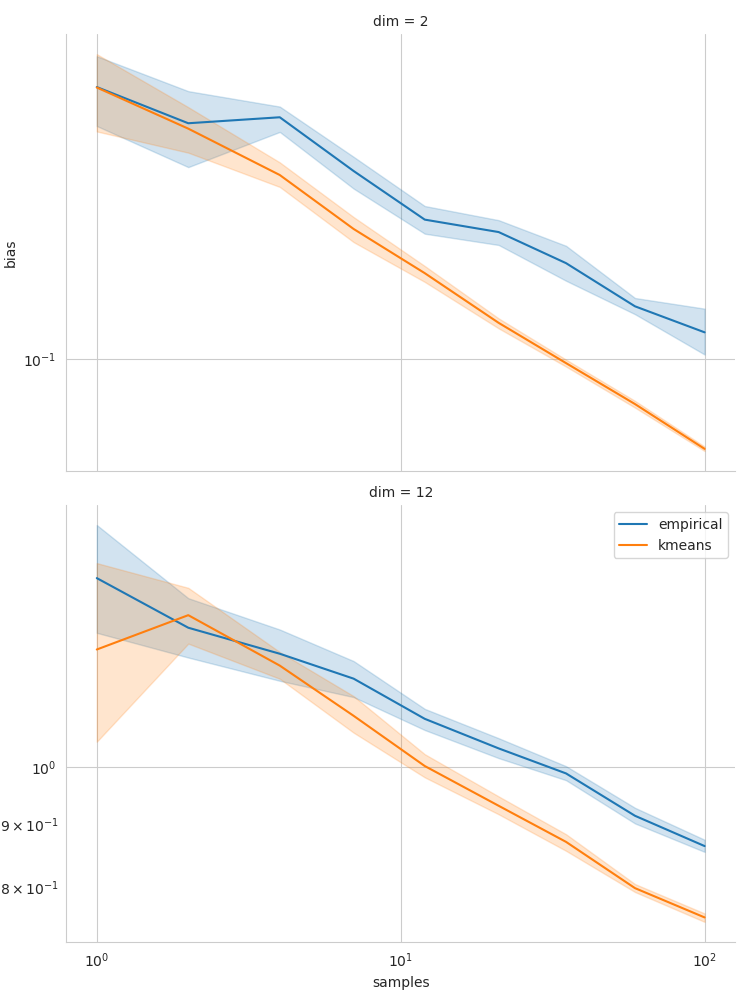

In [71]:
g = sns.FacetGrid(results, hue='method', row="dim", sharey=False, height=5, aspect=1.5)
g = g.map(sns.lineplot, "samples", "bias")
g = g.set(xscale='log', yscale='log')
plt.legend()

## Gaussian Mixtures

This is the synthetic discrete example of the article.

### Distributions

Choose the dimension and number of points of your dataset:

In [2]:
dim = 15
n_total = 10000
n_gaussian = 10

save_dir = Path('data/GM/')
assert save_dir.is_dir()

Define the Finite distributions:

In [3]:
alpha = {}
beta = {}

mixtures_proba = np.random.random((2, n_gaussian))
mixtures_proba = mixtures_proba / np.sum(mixtures_proba, axis=1)[:, np.newaxis]

mixtures_mean = np.random.random((2, n_gaussian, dim))
cov = np.stack([np.eye(dim)]*n_gaussian)

for std in [.1, 1e-4]:
    alpha[std] = ContinuousDistribution.gaussian_mixture(mixtures_proba[0], mixtures_mean[0], cov * std).to_discrete(n_total, replace=True)
    beta[std] = ContinuousDistribution.gaussian_mixture(mixtures_proba[1], mixtures_mean[1], cov * std).to_discrete(n_total, replace=True)

Save them for later if you want reproducible results:

Reload them with:

Compute the true OT distance between the point clouds. It can be long. Use the duality gap to check that the solution is accurate.

In [4]:
true_ot = {}
for std in alpha:
    print(f"Computing for std = {std:.1e}")
    result = alpha[std].emd(beta[std], metric="cityblock")
    print(f"Cost: {result.transport_cost:.1e}. Duality gap: {result.duality_gap:.1e}")
    ### IF METRIC = SQEUCLIDEAN DON'T FORGET THE **.5
    true_ot[std] = result.transport_cost 

Computing for std = 1.0e-01


/home/gaspardb/miniconda3/envs/neurips/lib/python3.7/site-packages/ot/lp/__init__.py:113: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


Cost: 4.0e+00. Duality gap: -4.6e-14
Computing for std = 1.0e-04
Cost: 4.2e+00. Duality gap: 1.5e-12


Saving true OT distances:

#### Behaviour at low std

When the std goes to 0, we should get the cost between the means. Just in case: 

In [5]:
from scipy.spatial.distance import cdist

cost_mixture = cdist(*mixtures_mean, metric='cityblock')
ot_mixture = emd(*mixtures_proba, cost_mixture)

ot_mixture.transport_cost

4.211435628030824

### Define the estimators

In [17]:
estimators = {"kmeans": KMeansInit, 
              # "mc_kmeans": MCKMeansInit,
              "empirical": EmpiricalSampler,
             }

Here, let's try the L1 norm.

In [18]:
estimators = {std: {name: model(alpha[std], beta[std], metric_norm=1, prefactor_sampling=1) for name, model in estimators.items()} for std in alpha}

### Benchmark!

In [19]:
n_batch = 10  # 100 for more accuracy
val_to_try = np.logspace(0, 2, 20).astype(int)

val_to_try = np.flip(np.unique(val_to_try))

val_to_try

array([100,  78,  61,  48,  37,  29,  23,  18,  14,  11,   8,   6,   5,
         4,   3,   2,   1])

In [20]:
results = {}
for std in alpha:
    print(f"Doing std: {std}.\n")
    result_std = []
    for name, model in estimators[std].items():
        print(f"\tDoing model: {name}.")
        #### TAKE sqrt_cost=True WITH SQEUCLIDEAN DISTANCE
        result_benchmark = benchmark_ot(model, val_to_try, n_batch, sqrt_cost=False)
        result_std.append((name, result_benchmark))
    results[std] = join_benchmarks(result_std, optimal_cost=true_ot[std])
    results[std]['std'] = std
results = pd.concat(results.values())

Doing std: 0.1.

	Doing model: kmeans.



	Doing model: empirical.



Doing std: 0.0001.

	Doing model: kmeans.



	Doing model: empirical.


### Plots

<IPython.core.display.Javascript object>


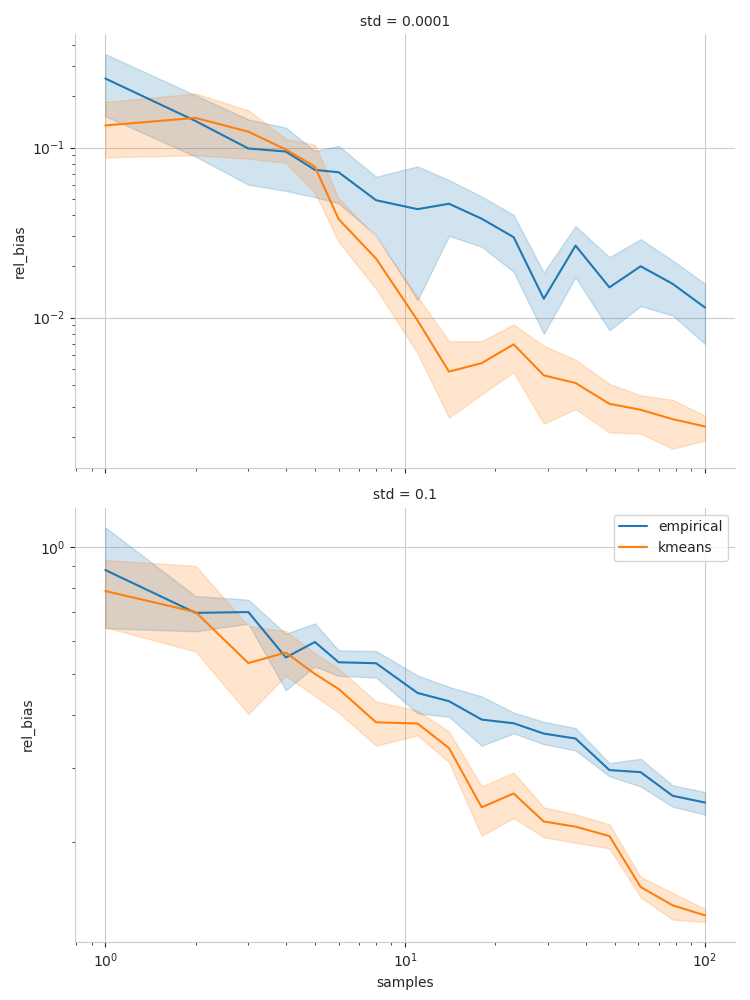

In [21]:
g = sns.FacetGrid(results, hue='method', row="std", sharey=False, height=5, aspect=1.5)
g = g.map(sns.lineplot, "samples", "rel_bias")
g = g.set(xscale='log', yscale='log')
plt.legend()

## Adult DS

### Distributions

In [22]:
save_dir = Path('data/adult')

X = pd.read_csv(save_dir / "adult.data", usecols=(0, 2, 10, 11, 12, 14), names=['age', 'fnlwgt', 'capital_gain', 'capital_loss', 'hours-per-week', 'target'])
X = X.iloc[:20000, :]  # CPU power limit
X, y = X.iloc[:, :-1].astype('float64'), X.iloc[:, -1] == ' <=50K'
X = (X - X.mean(0)) / X.std(0)

dim = X.shape[1]

In [23]:
alpha = FiniteDistribution(X.values[y, :dim], replace=True)
beta = FiniteDistribution(X.values[~y, :dim], replace=True)

Define the true distance between them:

true_ot = alpha.emd(beta, metric="sqeuclidean")

print(f"Duality gap is: {true_ot.duality_gap}. Cost is: {true_ot.transport_cost}")
true_ot = true_ot.transport_cost ** .5

In [24]:
true_ot = 6.295792339352144 ** .5

Additional steps for regularized transport.

<IPython.core.display.Javascript object>


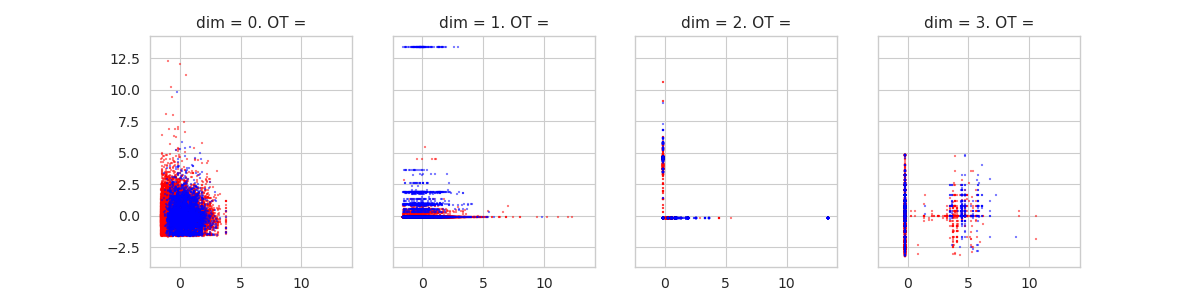

In [8]:
fig, axes = plt.subplots(1, dim-1, figsize=(12, 3), sharex=True, sharey=True)

for ax, d in zip(axes, range(dim-1)):
    ax.scatter(*alpha.support.T[[d, d+1], :], color='r', marker='+', alpha=.5, s=1)
    ax.scatter(*beta.support.T[[d, d+1], :], color='b', marker='+', alpha=.5, s=1)
    ax.set_title(f"dim = {d:d}. OT =" #{true_ot[dim]:.1e}"
                 , fontsize=11)

### Define the estimators

We make the preprocessing time competitive by using AFK-MC² with few samples.

In [26]:
# Prefactor on the number of samples (Kappa in the article)
prefactor_sampling=.1

# Choose L1 or L2 norm
metric_norm = 2

estimators = {
    "kmeans": KMeansInit(alpha, beta, prefactor_sampling=prefactor_sampling, metric_norm=metric_norm),
    "mc_kmeans": MCKMeansInit(alpha, beta, chain_length=100, r_sampled=2.,
                              prefactor_sampling=prefactor_sampling, metric_norm=metric_norm),
    "empirical": EmpiricalSampler(alpha, beta, metric_norm=2)
             }

# Regularized estimator ; take care to use the good target value for true_ot!
# estimators = {
#     "mc_kmeans_reg": MCKMeansInitRegularized(alpha, beta, metric_norm=2, prefactor_sampling=.05, chain_length=50, r_sampled=2., eps=1.),
#     "empirical_reg": EmpiricalSamplerRegularized(alpha, beta, eps=1.)
#              }

### Benchmark!

In [49]:
n_batch = 10
val_to_try = {"kmeans": np.logspace(0, 2, 10),
              "empirical": np.logspace(0, 3, 10),
              "mc_kmeans": np.logspace(0, 2, 10),
             }
# val_to_try = [1, 5, 10]
val_to_try = {k: np.flip(np.unique(v.astype(int))) for k, v in val_to_try.items()}

val_to_try

{'kmeans': array([100,  59,  35,  21,  12,   7,   4,   2,   1]),
 'empirical': array([1000,  464,  215,  100,   46,   21,   10,    4,    2,    1]),
 'mc_kmeans': array([100,  59,  35,  21,  12,   7,   4,   2,   1])}

In [54]:
result_estimator = []

for name, model in estimators.items():
    print(f"\tDoing model: {name}.")
    result_benchmark = benchmark_ot(model, val_to_try[name], n_batch, sqrt_cost=True)
    result_estimator.append((name, result_benchmark))
results = join_benchmarks(result_estimator, optimal_cost=true_ot)


	Doing model: kmeans.



	Doing model: mc_kmeans.



	Doing model: empirical.


### Plots

<IPython.core.display.Javascript object>


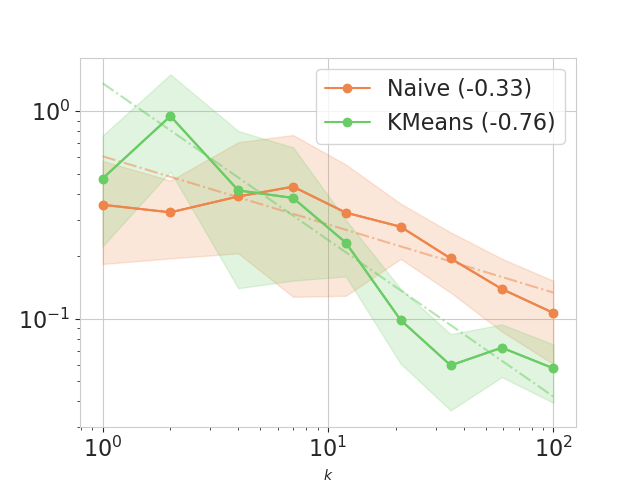

In [37]:
### BIAS PLOTS

fig, ax = plt.subplots()
_ = result_to_axes(results[results['method'].isin(['empirical', 'kmeans'])
                      ].reset_index(),
               hue='method', x='samples', y='rel_bias', 
               axes=ax,
               hue_names={'kmeans': "KMeans", 
                          "empirical": "Naive"},
               hue_color={'kmeans': CMAPS_SEQUENTIAL[1], 
                          'empirical': CMAPS_SEQUENTIAL[0]},
               xylabels=('$k$', ""), quantile=0, ci=True)

# savefig(fig, save_dir, name='adult_REGULARIZED.pdf')

<IPython.core.display.Javascript object>


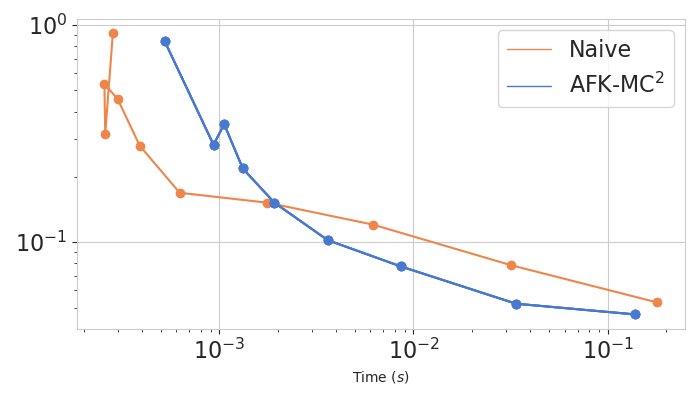

Saved to: data/adult/adult_cpu_timeULARIZED.pdf


In [55]:
# A bit ugly
results_tmp = results.groupby(['method', 'samples']).mean()[['t_tot', 'rel_bias']]
# x, y = 'samples', 'rel_bias'
x, y = 't_tot', 'rel_bias'
colors = {'empirical': CMAPS_SEQUENTIAL[0],
          'mc_kmeans': CMAPS_SEQUENTIAL[2]}
xylabels = 'Time ($s$)', ""

fig, ax = plt.subplots()

# Empirical
df = results_tmp.xs(('empirical'), level=('method'))
df = df.reset_index()
l_empir = ax.plot(df[x], df[y], color=colors['empirical'], marker="o")

# Others
l_others = {}
for p in [.1, .5, 1]:
    for method in ['mc_kmeans']:
        df = results_tmp.xs((method), level=('method')).reset_index()
        # Method and prefactor are set
        ax.plot(df[x], df[y], color=colors[method], marker='o')

ax.set_xscale('log')
ax.set_yscale('log')
    
custom_lines = [Line2D([0], [0], color=colors['empirical'], lw=1),
                Line2D([0], [0], color=colors["mc_kmeans"], lw=1),
               ]

plt.legend(custom_lines, ['Naive', 'AFK-MC$^2$'], fontsize=FONTSIZE_LEGEND)
ax.set_xlabel(xylabels[0])
ax.set_ylabel(xylabels[1])
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rc('xtick', labelsize=FONTSIZE_LEGEND)
plt.rc('ytick', labelsize=FONTSIZE_LEGEND)

savefig(fig, save_dir, 'adult_cpu_timeULARIZED.pdf')

<IPython.core.display.Javascript object>


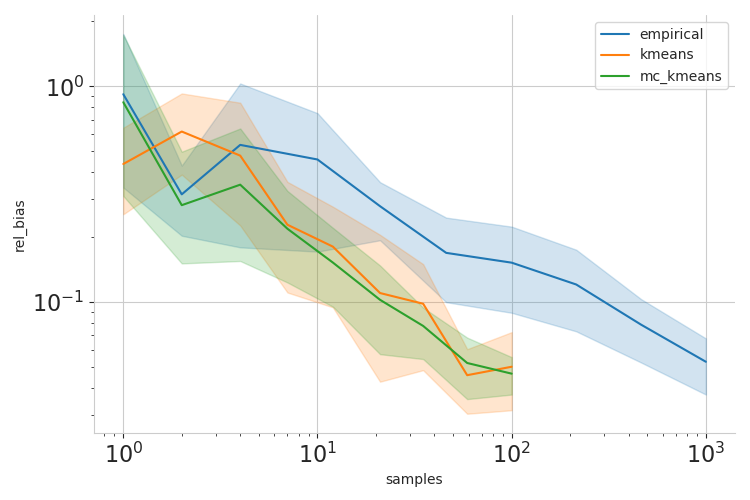

In [56]:
g = sns.FacetGrid(results, hue='method', sharey=False, height=5, aspect=1.5)
g = g.map(sns.lineplot, "samples", "rel_bias")
g = g.set(xscale='log', yscale='log')
plt.legend()

## DOT benchmark

Now, with the DOT dataset.

In [57]:
path_data = Path('data/DOT')
assert path_data.is_dir()

save_dir = path_save = Path('data/DOT/')
assert path_save.is_dir()

possible_types = list(map(lambda x: x.name, (path_data / 'Data').iterdir()))
print(possible_types)

['Shapes', 'WhiteNoise', 'CauchyDensity', 'LogGRF', 'GRFsmooth', 'MicroscopyImages', 'GRFmoderate', 'LogitGRF', 'GRFrough', 'ClassicImages']


A small function to turn an image into a distribution:

In [58]:
def image_to_distribution(image_path: Path):
    assert image_path.is_file()
    image = np.loadtxt(image_path, delimiter=',')
    n, m = image.shape
    
    coordinates = np.stack([np.arange(n)[:, np.newaxis] * np.ones(n), 
                            np.arange(m) * np.ones(m)[:, np.newaxis]]
                          ).transpose().reshape(-1, 2)
    weights = image.flatten()
    weights = weights / np.sum(weights)
    
    return FiniteDistribution(coordinates, weights, replace=True)

Choose the image set:

In [59]:
type_image = "MicroscopyImages"
path_data = path_data / 'Data' / type_image
path_pictures = path_data / 'Pictures' / type_image
assert path_data.is_dir()

Choose the image resolution:

In [60]:
resolution = 128

list_of_images = list(path_data.glob(f'data{resolution}_*.csv'))

### Defining the estimators

Choose the hyperparameter:

In [61]:
prefactor = 1

Choose the estimators you want to test:

In [62]:
estimators_names = {
    "kmeans": KMeansInit, 
    "mc_kmeans": MCKMeansInit,
    "empirical": EmpiricalSampler,
                    }

estimators = {}
distributions = {}
for i, j in itertools.combinations(range(10), 2):
    distribution_ij = image_to_distribution(list_of_images[i]), image_to_distribution(list_of_images[j])
    distributions[(i, j)] = distribution_ij
    estimators[(i, j)] = {name: model(*distribution_ij, prefactor_sampling=prefactor) for name, model in estimators_names.items()}

Compute the true OT:

In [ ]:
true_ot = {}

for (i, j) in tqdm(distributions, total=len(distributions)):
    alpha, beta = distributions[(i, j)]
    true_ot[(i, j)] = alpha.emd(beta, metric="sqeuclidean").transport_cost ** .5

/home/gaspardb/miniconda3/envs/OT3.7/lib/python3.7/site-packages/ot/lp/__init__.py:113: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


And save it for later:

Reload it with:

Define the parameters:

In [63]:
n_batch = 100
val_to_try = {"kmeans": np.logspace(0, 2, 10),
              "empirical": np.logspace(0, 3, 15)}

val_to_try = {k: np.flip(np.unique(v.astype(int))) for k, v in val_to_try.items()}

val_to_try

{'kmeans': array([100,  59,  35,  21,  12,   7,   4,   2,   1]),
 'empirical': array([1000,  610,  372,  227,  138,   84,   51,   31,   19,   11,    7,
           4,    2,    1])}

Run the benchmark!

In [62]:
results = {}
for (i, j) in tqdm(estimators, total=len(estimators)):
#     print(f"Doing image: {i, j}.\n")
    result_ij = []
    for name, model in estimators[(i, j)].items():
#         print(f"\tDoing model: {name}.")
        result_benchmark = benchmark_ot(model, val_to_try[name], n_batch)
        result_ij.append((name, result_benchmark))
    results[(i, j)] = join_benchmarks(result_ij, optimal_cost=true_ot[(i, j)])
    results[(i, j)]['i'] = i
    results[(i, j)]['j'] = j